In [83]:
import datetime
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import plots
from tqdm.notebook import tqdm
from utils import ClosestIndexDict

In [84]:
data = ClosestIndexDict()
with open("data.csv") as f:
    x = f.readline()
    for l in f.readlines():
        l = l.split(',')
        date = datetime.datetime.strptime(l[0], "%m/%d/%y")
        close = float(l[4])
        data[date] = close

In [85]:
def date_range(start, end, n_periods) -> Sequence[datetime.datetime]:
    freq = (end-start) / n_periods
    dates = np.arange(start, end, freq).astype(datetime.datetime)
    dates = np.append(dates, end)
    return dates

In [86]:
def compute_benefit(
    q: float,
    buy_dates: Sequence[datetime.datetime],
    sell_date: datetime.datetime,
    prices: ClosestIndexDict) -> float:
    
    q /= len(buy_dates)
    buy_prices = np.array([prices[d] for d in buy_dates])
    n_stocks = sum(q / buy_prices)
    benefit = n_stocks * prices[sell_date]
    return benefit

def total_benefit(prices: ClosestIndexDict, start_date: datetime.datetime,length: int, n_periods: int):
    investment_length = datetime.timedelta(days=length)
    end_date = start_date + investment_length
    dates = date_range(start_date, end_date, n_periods)
    buy_dates = dates[:-1]
    sell_date = dates[-1]
    b = compute_benefit( q=1, buy_dates=buy_dates, sell_date=sell_date, prices=prices)
    return b

In [87]:
starting_dates = date_range(start=datetime.datetime(1980, 1, 1),
                            end=datetime.datetime(2018, 1, 1),
                            n_periods=365*38)
bs_dca = []
bs_ls = []
length = 365 * 5
for sd in starting_dates:
    b_dca = total_benefit(prices=data, start_date=sd, length=length, n_periods=(365*5)/30)
    b_ls = total_benefit(prices=data, start_date=sd, length=length, n_periods=1)

    bs_dca.append(b_dca)
    bs_ls.append(b_ls)

bs_dca = np.array(bs_dca)
bs_ls = np.array(bs_ls)

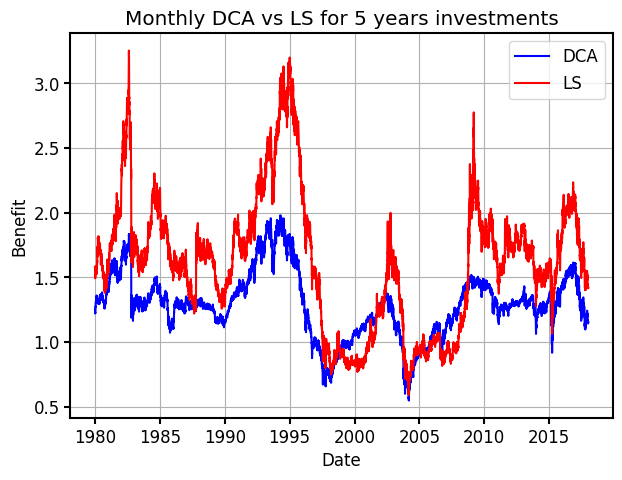

In [88]:
plt.plot(starting_dates, bs_dca, label='DCA', c='b')
plt.plot(starting_dates, bs_ls, label='LS', c='r', ls='-')
plt.legend()
plt.title("Monthly DCA vs LS for 5 years investments")
plt.xlabel("Date")
plt.ylabel("Benefit")

plt.savefig("/Users/a.molasmartin/Documents/workspace/personal-website/docs/dca-is-suboptimal/dca-vs-ls.svg")

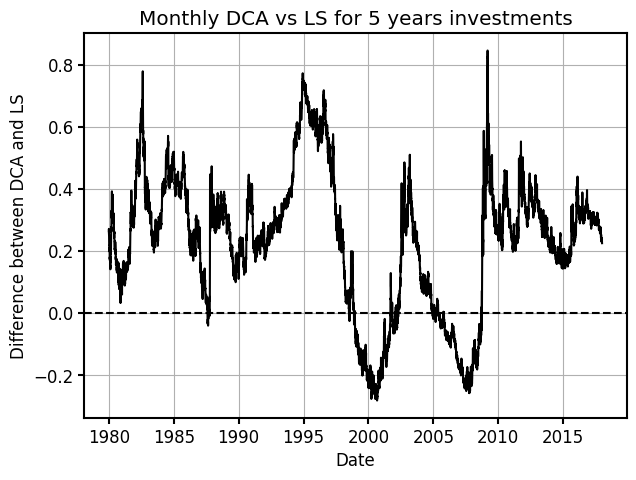

In [89]:
plt.plot(starting_dates, (bs_ls - bs_dca) / bs_dca)
plt.axhline(0, ls='--')
plt.xlabel("Date")
plt.ylabel("Difference between DCA and LS")
plt.title("Monthly DCA vs LS for 5 years investments")
plt.savefig("/Users/a.molasmartin/Documents/workspace/personal-website/docs/dca-is-suboptimal/dca-vs-ls-2.svg")

In [90]:
(bs_ls > bs_dca).mean()

0.8200692041522492

In [91]:
((bs_ls - bs_dca) / bs_dca).mean()

0.22944194981410374

# Varying period

In [92]:
start = datetime.datetime(1980, 1, 1)
end = datetime.datetime(2015, 1, 1)

starting_dates = date_range(start=start, end=end, n_periods=(end-start).days/10)

length = 365*5
periods = [1, 2, 5, 10, 20, 45, 90, 180, 360]

periods_mean_improvement = []

for period in tqdm(periods):
    bs_dca = []
    bs_ls = []
    for sd in starting_dates:
        b_dca = total_benefit(prices=data, start_date=sd, length=length, n_periods=period)
        b_ls = total_benefit(prices=data, start_date=sd, length=length, n_periods=1)
        bs_dca.append(b_dca)
        bs_ls.append(b_ls)

    bs_dca = np.array(bs_dca)
    bs_ls = np.array(bs_ls)
    m = ((bs_ls - bs_dca) / bs_dca).mean()
    periods_mean_improvement.append(m)

  0%|          | 0/9 [00:00<?, ?it/s]

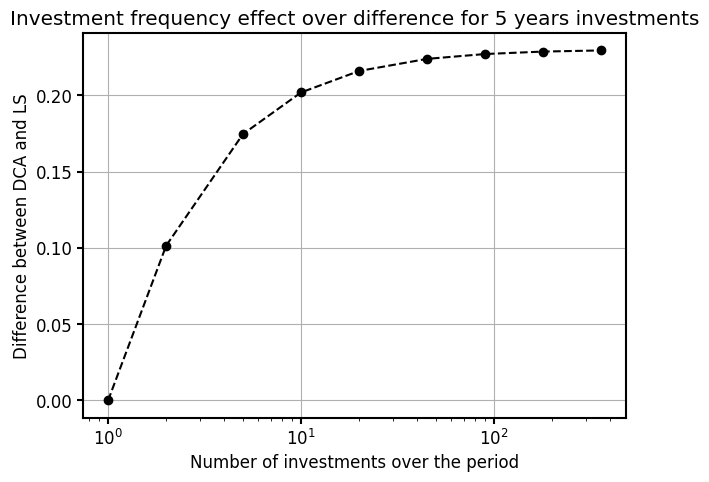

In [93]:
plt.plot(periods, periods_mean_improvement, '--o')
plt.xscale('log')
plt.title("Investment frequency effect over difference for 5 years investments")
plt.xlabel("Number of investments over the period")
plt.ylabel("Difference between DCA and LS")
plt.savefig("/Users/a.molasmartin/Documents/workspace/personal-website/docs/dca-is-suboptimal/period-vs-difference.svg")

# Varying length

In [94]:
def compute_benefit(
    q: float,
    buy_dates: Sequence[datetime.datetime],
    sell_date: datetime.datetime,
    prices: ClosestIndexDict) -> float:
    
    q /= len(buy_dates)
    buy_prices = np.array([prices[d] for d in buy_dates])
    n_stocks = sum(q / buy_prices)
    benefit = n_stocks * prices[sell_date]
    return benefit

def total_benefit(prices: ClosestIndexDict, start_date: datetime.datetime,length: int, n_periods: int):
    end_date = start_date + datetime.timedelta(days=length)
    dates = date_range(start_date, end_date, n_periods)
    buy_dates = dates[:-1]
    sell_date = dates[-1]
    b = compute_benefit(q=1, buy_dates=buy_dates, sell_date=sell_date, prices=prices)
    return b



In [95]:
start = datetime.datetime(1980, 1, 1)
end = datetime.datetime(2015, 1, 1)


starting_dates = date_range(start=start,
                            end=end,
                            n_periods=(end-start).days)
lengths = [45, 90, 180, 360, 720, 1440, 2880]

length_mean_improvement = []

for l in tqdm(lengths):
    bs_dca = []
    bs_ls = []
    for sd in starting_dates:
        b_dca = total_benefit(prices=data, start_date=sd, length=l, n_periods=l/30)
        b_ls = total_benefit(prices=data, start_date=sd, length=l, n_periods=1)
        bs_dca.append(b_dca)
        bs_ls.append(b_ls)

    bs_dca = np.array(bs_dca)
    bs_ls = np.array(bs_ls)
    
    m = ((bs_ls - bs_dca) / bs_dca).mean()
    length_mean_improvement.append(m)

  0%|          | 0/7 [00:00<?, ?it/s]

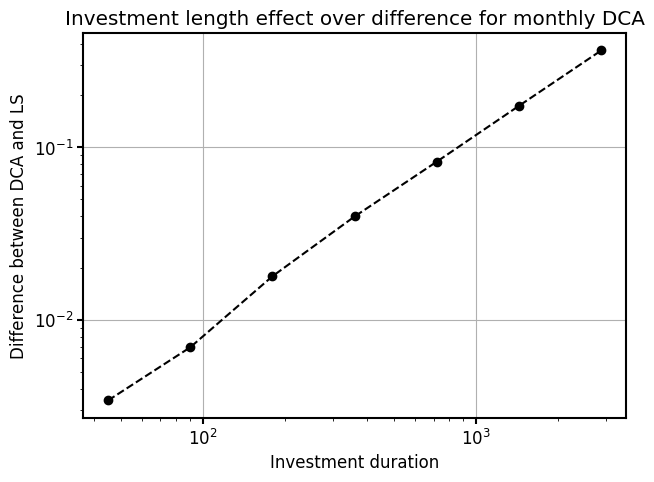

In [96]:
plt.plot(lengths, length_mean_improvement, '--o')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Investment duration")
plt.title("Investment length effect over difference for monthly DCA")
plt.ylabel("Difference between DCA and LS")
plt.savefig("/Users/a.molasmartin/Documents/workspace/personal-website/docs/dca-is-suboptimal/length-vs-difference.svg")